Michael Wilson
DSC-609: Machine Learning
Ensemble Methods


## Dataset

The dataset being used is the Vehicles table, from the United States Environmental Protection Agency (EPA).  Available in multiple formats, regularly updated, and can be downloaded through FuelEconomy.gov (EPA, 2021).  

For this assignment, we are focusing on predicting the class label for Gas-Guzzler status.  So that feature in the Vehicles table is our dependent variable.  We will train models using the independent variables of carbon-dioxide tailpipe emissions, number of cylinders in the engine, displacement of the engine, drive-train configuration (simplified to 2 or 4, the number of driven wheels, part-time 4 wheel-drive is considered as 4 driven wheels.), use of a turbocharger or supercharger on the engine, presence of Stop-Start programming (engine shuts off during idle situations), and fuel type.

### Pre-processing

To begin, we load all of the packages that will be required to execute our tasks.  Then, read in the file, and do data cleansing to recode categorical variables, drop unnecessary columns, fill missing values or delete rows with them, and sub-select our data sample.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

In [2]:
# Read in file
OriginalDataSet = pd.read_csv(r'C:\Users\Mike\Documents\Grad School 2021\DSC-609 Machine Learning\vehicles.csv',
                              usecols = ['co2TailpipeGpm','cylinders','displ','drive',
                                         'tCharger','sCharger','fuelType1','year','make','model','startStop',
                                         'guzzler'], dtype = {'startStop': 'str'})

OriginalDataSet.head()

,co2TailpipeGpm,cylinders,displ,drive,fuelType1,make,model,year,guzzler,tCharger,sCharger,startStop
0,423.190476,4.0,2.0,Rear-Wheel Drive,Regular Gasoline,Alfa Romeo,Spider Veloce 2000,1985,NaN,NaN,NaN,NaN
1,807.909091,12.0,4.9,Rear-Wheel Drive,Regular Gasoline,Ferrari,Testarossa,1985,T,NaN,NaN,NaN
2,329.148148,4.0,2.2,Front-Wheel Drive,Regular Gasoline,Dodge,Charger,1985,NaN,NaN,NaN,NaN
3,807.909091,8.0,5.2,Rear-Wheel Drive,Regular Gasoline,Dodge,B150/B250 Wagon 2WD,1985,NaN,NaN,NaN,NaN
4,467.736842,4.0,2.2,4-Wheel or All-Wheel Drive,Premium Gasoline,Subaru,Legacy AWD Turbo,1993,NaN,T,NaN,NaN


In [3]:
# Reduce to the years 2005 thrugh 2010
GG_Dataset = OriginalDataSet[(OriginalDataSet['year'] >= 2005) & (OriginalDataSet['year'] <= 2010)]

# Infer data types - Some strings stored as objects
GG_Dataset = GG_Dataset.convert_dtypes()

# Eliminate rows that omitted this response (only 1 record - the Mini-E)
GG_Dataset = GG_Dataset[GG_Dataset.drive.notnull()]

# Recode categorical variables
GG_Dataset.drive.replace(to_replace = ['Rear-Wheel Drive','Front-Wheel Drive','2-Wheel Drive'], value = 2,
                         inplace = True)
GG_Dataset.drive.replace(to_replace = ['4-Wheel or All-Wheel Drive','All-Wheel Drive','4-Wheel Drive',
                                       'Part-time 4-Wheel Drive'], value = 4, inplace = True)

GG_Dataset.guzzler.replace(to_replace = ['G','S'], value = ['Y','Y'], inplace = True)
GG_Dataset['guzzler'].mask(GG_Dataset['guzzler'] != 'Y', 'N', inplace = True)

GG_Dataset.tCharger.replace(to_replace = ['T'], value = 1, inplace = True)
GG_Dataset.tCharger.mask(GG_Dataset['tCharger'] != 1, 0, inplace = True)

GG_Dataset.sCharger.replace(to_replace = ['S'], value = 1, inplace = True)
GG_Dataset.sCharger.mask(GG_Dataset['sCharger'] != 1, 0, inplace = True)

GG_Dataset.startStop.replace(to_replace = ['Y'], value = 1, inplace = True)
GG_Dataset.startStop.mask(GG_Dataset['startStop'] != 1, 0, inplace = True)

fuel_dummies =  pd.get_dummies(GG_Dataset['fuelType1'])
GG_Dataset = pd.concat([GG_Dataset, fuel_dummies], axis = 1)

GG_Dataset.head()

,co2TailpipeGpm,cylinders,displ,drive,fuelType1,make,model,year,guzzler,tCharger,sCharger,startStop,Diesel,Natural Gas,Premium Gasoline,Regular Gasoline
11614,493.722222,6,3.0,2,Premium Gasoline,Acura,NSX,2005,N,0,0,0,0,0,1,0
11615,493.722222,6,3.2,2,Premium Gasoline,Acura,NSX,2005,N,0,0,0,0,0,1,0
11616,423.190476,4,1.8,2,Premium Gasoline,Audi,TT Roadster,2005,N,1,0,0,0,0,1,0
11617,423.190476,4,1.8,4,Premium Gasoline,Audi,TT Roadster quattro,2005,N,1,0,0,0,0,1,0
11618,467.736842,6,3.2,4,Premium Gasoline,Audi,TT Roadster quattro,2005,N,0,0,0,0,0,1,0


#### Summary Statistics on Dataset

In [4]:
GG_Dataset.describe()

,co2TailpipeGpm,cylinders,displ,drive,year,Diesel,Natural Gas,Premium Gasoline,Regular Gasoline
count,6869.000000,6869.000000,6869.000000,6869.000000,6869.000000,6869.000000,6869.000000,6869.00000,6869.000000
mean,479.346141,6.083709,3.558611,2.669093,2007.499345,0.008298,0.001456,0.39671,0.593536
std,103.416508,1.822930,1.273640,0.943732,1.703026,0.090722,0.038130,0.48925,0.491209
min,170.903846,2.000000,1.000000,2.000000,2005.000000,0.000000,0.000000,0.00000,0.000000
25%,403.954545,4.000000,2.500000,2.000000,2006.000000,0.000000,0.000000,0.00000,0.000000
50%,467.736842,6.000000,3.500000,2.000000,2008.000000,0.000000,0.000000,0.00000,1.000000
75%,555.437500,8.000000,4.400000,4.000000,2009.000000,0.000000,0.000000,1.00000,1.000000
max,987.444444,16.000000,8.400000,4.000000,2010.000000,1.000000,1.000000,1.00000,1.000000


In [5]:
# Reduce the dataset to just the independent and dependent variables

GG_model_dataset = GG_Dataset.drop(['fuelType1','make','model','year'], axis = 1)

GG_model_dataset

,co2TailpipeGpm,cylinders,displ,drive,guzzler,tCharger,sCharger,startStop,Diesel,Natural Gas,Premium Gasoline,Regular Gasoline
11614,493.722222,6,3.0,2,N,0,0,0,0,0,1,0
11615,493.722222,6,3.2,2,N,0,0,0,0,0,1,0
11616,423.190476,4,1.8,2,N,1,0,0,0,0,1,0
11617,423.190476,4,1.8,4,N,1,0,0,0,0,1,0
11618,467.736842,6,3.2,4,N,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23408,592.466667,8,6.1,2,Y,0,0,0,0,0,1,0
23410,493.722222,8,4.4,4,N,1,0,0,0,0,1,0
23411,592.466667,8,6.1,2,Y,0,0,0,0,0,1,0
26992,592.466667,8,6.2,2,N,0,0,0,0,0,0,1


In [6]:
# Split data into training and testing sets

target = GG_model_dataset['guzzler']
Predictors = GG_model_dataset.drop(['guzzler'], axis = 1)

Predictors_train, Predictors_test, target_train, target_test = train_test_split(Predictors, target,
                                                                                random_state = 0)

feature_names = Predictors_train.columns

### Random Forest

Using default number of trees to build of 100, and setting max_features equal to 5, and 10-fold cross-validation:

In [7]:
GG_Forest = RandomForestClassifier(max_features = 5, random_state = 0)
GG_Forest.fit(Predictors_train, target_train)

Forest_scores = cross_val_score(GG_Forest, Predictors_train, target_train, cv = 10)

fold = 0
for score in Forest_scores:
    fold = fold + 1
    print('CV Score - Fold #',fold,'\t:', round(score, 3))

print('Average CV score on training set: {:.3f}'.format(Forest_scores.mean()))

CV Score - Fold # 1 	: 0.986
CV Score - Fold # 2 	: 0.986
CV Score - Fold # 3 	: 0.986
CV Score - Fold # 4 	: 0.99
CV Score - Fold # 5 	: 0.99
CV Score - Fold # 6 	: 0.986
CV Score - Fold # 7 	: 0.988
CV Score - Fold # 8 	: 0.996
CV Score - Fold # 9 	: 0.99
CV Score - Fold # 10 	: 0.988
Average CV score on training set: 0.989


### Gradient Boosting

Also using default settings for number of trees to build of 100, and default learning rate of 0.1:

In [8]:
GG_gradient = GradientBoostingClassifier(random_state = 0, learning_rate = 0.1)
GG_gradient.fit(Predictors_train, target_train)

Boosted_scores = cross_val_score(GG_gradient, Predictors_train, target_train, cv = 10)

fold = 0
for score in Boosted_scores:
    fold = fold + 1
    print('CV Score - Fold #',fold,'\t:', round(score, 3))

print('Average CV score on training set: {:.3f}'.format(Boosted_scores.mean()))

CV Score - Fold # 1 	: 0.99
CV Score - Fold # 2 	: 0.986
CV Score - Fold # 3 	: 0.983
CV Score - Fold # 4 	: 0.988
CV Score - Fold # 5 	: 0.986
CV Score - Fold # 6 	: 0.975
CV Score - Fold # 7 	: 0.984
CV Score - Fold # 8 	: 0.986
CV Score - Fold # 9 	: 0.973
CV Score - Fold # 10 	: 0.981
Average CV score on training set: 0.983


### Model Score Comparison

Using the default/common class settings for the algorithms shows us that we should expect the Random Forest Classifier to provide slightly better performance, at 98.9 versus 98.3% for an average cross-validation score.  However, that is on default settings.  Parameter tuning, either number of trees or learning rate on the Gradient-Boosted model, can be attempted to see if the classification accuracy could be improved.  At 98%+ for both models, they both do a good job of predicting the class already.

Let's take a look at feature importances found by the two ensemble methods:

#### Random Forest Feature Importance

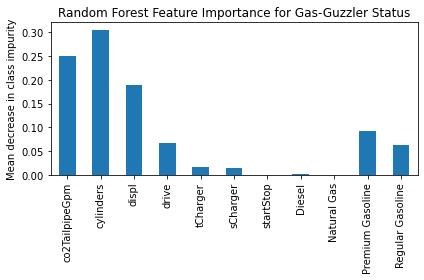

In [9]:
GG_importance1 = GG_Forest.feature_importances_

GG_Forest_Importance = pd.Series(GG_importance1, index = feature_names)

fig, ax = plt.subplots()
GG_Forest_Importance.plot.bar(ax = ax)
ax.set_title('Random Forest Feature Importance for Gas-Guzzler Status')
ax.set_ylabel('Mean decrease in class impurity')
fig.tight_layout()

#### Gradient-Boosted Feature Importance

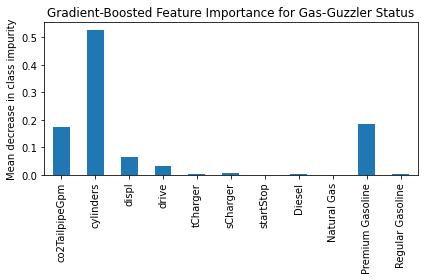

In [10]:
GG_importance2 = GG_gradient.feature_importances_

GG_Gradient_Importance = pd.Series(GG_importance2, index = feature_names)

fig, ax = plt.subplots()
GG_Gradient_Importance.plot.bar(ax = ax)
ax.set_title('Gradient-Boosted Feature Importance for Gas-Guzzler Status')
ax.set_ylabel('Mean decrease in class impurity')
fig.tight_layout()

Looking between the two feature importance graphs, we see strong agreement between the models on some variables, but the gradient-boosted method found fewer features important than the random forest model did.  Everywhere the gradient-boosted model found a feature important, the random forest did, as well, but the random forest found additional features important.  

#### References:

United States Environmental Protection Agency. (2021). Vehicles.csv [Data set] Retrieved from: https://www.fueleconomy.gov/feg/epadata/vehicles.csv (Accessed 17 Nov 2021).